In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
np.float = float
np.bool = bool
np.int = int
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import time
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import utils
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df_meta = pd.read_csv("/Users/labadmin/Projects/immusign/data/lymphoma-reps-file-infos.csv")
lymphoma_types = df_meta["lymphoma_specification"].unique()

In [3]:
df_meta.columns

Index(['pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'clones.txt.name', 'subject_id', 'sex',
       'dosc', 'age', 'dob'],
      dtype='object')

In [4]:
lymphoma_types

array(['cll', 'hd', 'unspecified', 'abc_dlbcl', 'nlphl', 'thrlbcl',
       'dlbcl', 'lymphadenitis', 'gcb_dlbcl'], dtype=object)

In [9]:
df_raw = utils.read_clones_txt(df_meta["clones.txt.name"].values, "/Users/labadmin/Projects/immusign/data/clones_mit_kidera")
df_raw["cloneFraction"] = df_raw["cloneFraction"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))

  0%|          | 0/1394 [00:00<?, ?it/s]

In [51]:
df_raw.columns

Index(['cloneId', 'cloneCount', 'cloneFraction', 'nSeqCDR3', 'aaSeqCDR3',
       'bestVGene', 'bestDGene', 'bestJGene', 'vBestIdentityPercent',
       'lengthOfCDR3', 'targetSequences', 'allVGenes', 'allDGenes',
       'allJGenes', 'allVHits', 'allDHits', 'allJHits', 'allVAlignments',
       'allDAlignments', 'allJAlignments', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5',
       'KF6', 'KF7', 'KF8', 'KF9', 'KF10', 'clones.txt.name',
       'dBestIdentityPercent', 'jBestIdentityPercent', 'aaSeqCDR2',
       'aaSeqCDR1', 'aaSeqFR2', 'aaSeqFR3', 'aaSeqFR4',
       'aaSeqImputedVDJRegion'],
      dtype='object')

# Load Data read from R-Script

In [51]:
import rpy2.robjects as robjects
robjects.r['load']("/Users/labadmin/Projects/immusign/immusign_40000_reads_with_out_of_frame.RData")
twb = robjects.r['twb']

In [52]:
df = utils.convert_rtwb_to_pdtwb(twb)

In [53]:
df["clones.txt.name"] = df["sample"].apply(lambda x: x + ".clones.txt")

In [20]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name'],
      dtype='object')

# Add metric info

In [21]:
stats = pd.read_csv("/Users/labadmin/Projects/immusign/output/stats.csv", sep=";")
stats.rename(columns={stats.columns[0]:"sample"}, inplace=True)

In [22]:
df = df.merge(stats.iloc[:-2], on = "sample")

# Add meta info

In [23]:
df = df.merge(df_meta, on = "clones.txt.name")

In [24]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob'],
      dtype='object')

# Add correct clone Id before adding info from raw files

In [108]:
df["cloneId"] = None

for file in tqdm(df["clones.txt.name"].unique()):
    df_sub_file = df[df["clones.txt.name"] == file]
    df_raw_sub_file = df_raw[df_raw["clones.txt.name"] == file]
    for i, index_row in enumerate(df_sub_file.iterrows()):
        index, row = index_row[0], index_row[1]  
        if row["CDR3.nucleotide.sequence"] == df_raw_sub_file.iloc[i]["nSeqCDR3"]:
            df.loc[index,"cloneId"] = df_raw_sub_file.iloc[i]["cloneId"]

  0%|          | 0/679 [00:00<?, ?it/s]

In [116]:
df2 = df.merge(df_raw, left_on=["clones.txt.name", "cloneId", "CDR3.nucleotide.sequence"], right_on =["clones.txt.name", "cloneId", "nSeqCDR3"], how = "left")

In [55]:
df2.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [122]:
#df2.to_pickle("immusign_40000_reads_with_mutations_merged_raw_data.pkl")

In [91]:
#df.to_pickle("immusign_40000_reads_with_mutations_merged_raw_data_cleaned.pkl")

# Get rid of redundant information

In [76]:
#df = pd.read_pickle("immusign_40000_reads_with_out_of_frame_merged_raw_data.pkl")

### CDR3.amino.acid.sequence from R-scripts and aaSeqCDR3 from files not the same

In [ ]:
# test = df[~(df["CDR3.amino.acid.sequence"].apply(lambda x: x.replace("~", "_")) == df["aaSeqCDR3"])]

In [57]:
print(df["CDR3.amino.acid.sequence"].apply(lambda x: x.replace("~", "_")).loc[7])
print(df["aaSeqCDR3"].loc[7])

CASKSND_TGKGYW
CASKSN_TGKGYW


### bunch.translate function either drops 2 nucleotide (seq_len % 3 = 2) or repeats 2 nucleotides (seq_len % 2 = 1) leading to additional AS e.g. D in example above

In [77]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [90]:
df.drop(columns = ['Umi.count', 'Umi.proportion', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'nSeqCDR3'],inplace=True)

In [4]:
df["aaSeqCDR3"].unique()

array(['CARSPDHW', 'CARDVVVGYYYGMDVW', 'CASGYFEYSSSRPYGMDVW', ...,
       'CARAARQGSTGYYFFDYW', 'CARDLGRFSPPFCSGINCYEGGGFDPW',
       'CAREQEPYSNTDFW'], dtype=object)

In [5]:
df["Clonality"] = df["Clonality"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df["twb.shannon"] = df["twb.shannon"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df["twb.simp"] = df["twb.simp"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))

In [6]:
df["age"] = df["age"].apply(lambda x: utils.tryconvert(x, np.nan, float))

In [7]:
np.sum(df["age"].isnull())

213328

In [8]:
np.sum(df["sex"].isnull())

209223

In [42]:
unkown_sex_id = df[df["sex"].isnull()]["subject_id"].unique()

In [43]:
df[df.subject_id.isin(unkown_sex)][~df[df.subject_id.isin(unkown_sex)]["sex"].isnull()][["sex", "subject_id"]].groupby(["sex", "subject_id"]).first()

Empty DataFrame
Columns: []
Index: [(female, CLL394), (female, HD096), (male, CLL300), (male, CLL374), (male, DLBCL07)]

In [54]:
df[df.subject_id == "CLL394"][["clones.txt.name", "sex", "subject_id"]]
df[df.subject_id == "HD096"][["clones.txt.name", "sex", "subject_id"]]
df[df.subject_id == "CLL300"][["clones.txt.name", "sex", "subject_id"]]
df[df.subject_id == "CLL374"][["clones.txt.name", "sex", "subject_id"]]
df[df.subject_id == "DLBCL07"][["clones.txt.name", "sex", "subject_id"]]

,clones.txt.name,sex,subject_id
1195599,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
1195600,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
1195601,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
1195602,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
1195603,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
...,...,...,...
1195690,LisaS-hs-FR3-DLBCL07-II_S128.clones.txt,male,DLBCL07
1195691,LisaS-hs-FR3-DLBCL07-II_S128.clones.txt,male,DLBCL07
1195692,LisaS-hs-FR3-DLBCL07-II_S128.clones.txt,male,DLBCL07
1195693,LisaS-hs-FR3-DLBCL07-II_S128.clones.txt,male,DLBCL07


In [53]:
df.loc[df.subject_id == "CLL394","sex"] = "female"
df.loc[df.subject_id == "HD096","sex"] = "female"
df.loc[df.subject_id == "CLL300","sex"] = "male"
df.loc[df.subject_id == "CLL374","sex"] = "male"
df.loc[df.subject_id == "DLBCL07","sex"] = "male"

In [55]:
np.sum(df["sex"].isnull())

207410

In [56]:
unkown_age_id = df[df["age"].isnull()]["subject_id"].unique()

In [58]:
df[df.subject_id.isin(unkown_age_id)][~df[df.subject_id.isin(unkown_age_id)]["age"].isnull()][["age", "subject_id"]].groupby(["age", "subject_id"]).first()

Empty DataFrame
Columns: []
Index: [(38.0, HD096), (52.0, HD020), (59.0, CLL367), (61.0, CLL144), (63.0, CLL300), (63.0, CLL368), (64.0, CLL144), (64.0, CLL368), (65.0, CLL306), (66.0, CLL144), (66.0, CLL306), (66.0, CLL374), (67.0, CLL306), (71.0, CLL353), (72.0, CLL353), (72.0, CLL394), (90.0, DLBCL07)]

In [65]:
df.loc[df.subject_id == "CLL368",["age", ]].unique()

array([63., 64., nan])

In [112]:
for idx, row in df[df["age"].isnull()].iterrows():
    if (not pd.isnull(row.dob)) and (not pd.isnull(row.dosc)):
        df.loc[idx, "age"] = utils.from_dosc_and_dob_to_age(row.dob, row.dosc)

In [114]:
unkown_age_id = df[df["age"].isnull()]["subject_id"].unique()

In [117]:
df[df.subject_id.isin(unkown_age_id)][~df[df.subject_id.isin(unkown_age_id)]["age"].isnull()][["age", "subject_id"]].groupby(["age", "subject_id"]).first()

Empty DataFrame
Columns: []
Index: [(38.0, HD096), (52.0, HD020), (61.0, CLL144), (63.0, CLL300), (64.0, CLL144), (66.0, CLL144), (66.0, CLL374), (72.0, CLL394), (90.0, DLBCL07)]

In [133]:
df.loc[df.subject_id == "HD096","age"] = 38
df.loc[df.subject_id == "HD020","age"] = 52
df.loc[df.subject_id == "CLL300","age"] = 63
df.loc[df.subject_id == "CLL374","age"] = 66
df.loc[df.subject_id == "CLL394","age"] = 72
df.loc[df.subject_id == "DLBCL07","age"] = 90
df.loc[(df.subject_id == "CLL144") & (df.age.isnull()),"age"] = 65

In [134]:
np.sum(df["age"].isnull())

196150

In [135]:
df["has_mutation"] = df["aaSeqCDR3"].apply(lambda x: "_" in x or "*" in x)

In [136]:
#df.to_pickle("immusign/immusign_40000_reads_with_out_of_frame_merged_raw_data_cleaned.pkl")

# Small Analysis

In [2]:
df = pd.read_pickle("immusign/immusign_40000_reads_with_out_of_frame_merged_raw_data_cleaned.pkl")

In [5]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

## Columns
cloneId --> Identified clones per sample <br>
cloneCount --> Absolute number found in sample <br>
cloneFraction --> Relative number found in sample (Attention: smaller than cloneCount/sum(cloneCount) because cut off < 2<br>
nSeqCDR3 --> Nucleotid sequence <br>
aaSeqCDR3 --> Amino Acid Sequence <br>
bestVGene --> best matching VGene <br>
bestDGene --> best matching DGene <br>
bestJGene --> best matching JGene <br>
vBestIdentityPercent --> Certainty of best matching VGene <br>
lengthOfCDR3 --> length of nucleotid sequence <br>
targetSequences --> Full sequence of nSeqCDR3 <br>
allVGenes --> All possible matches of V genes<br>
allDGenes --> All possible matches of D genes <br>
allJGenes --> All possible matches of J genes <br>
allVHits --> All V hits <br>
allDHits --> All D hits <br>
allJHits --> All J hits <br>
allVAlignments --> Alignments for each V hit <br>
allDAlignments --> Alignments for each D hit <br>
allJAlignments --> Alignments for each J hit <br>
KF1 - KF10 --> Kidera Factors <br>
clones.txt.name --> Sample file <br>
dBestIdentityPercent  --> Certainty of best matching DGene  <br>
jBestIdentityPercent  --> Certainty of best matching JGene  <br>
aaSeqCDR2 --> Amino Acid Sequence <br>
aaSeqCDR1 --> Amino Acid Sequence <br>
aaSeqFR2 --> Amino Acid Sequence  <br>
aaSeqFR3 --> Amino Acid Sequence  <br>
aaSeqFR4 --> Amino Acid Sequence <br>
aaSeqImputedVDJRegion --> Amino Acid Sequence <br>
<br>
--- META DATA ---<br>
pcr_target_locus --> Target Region of PCR ('IGH', 'TRB', 'IGHFR3', 'IGHFR2', 'TRBFR3') <br>
organism --> Organism of sample (hs) <br>
template --> DNA <br>
tissue --> Blood or Tissue['pb', 'tm'] <br>
lymphoma_type --> Identified lymphoma type <br>
lymphoma_specification --> dentified lymphoma type <br>
subject_id <br>
sex <br>
dosc --> date of sample collection <br>
age <br>
dob -->  date of birth<br>


# Distribution of data

<Axes: xlabel='lymphoma_specification', ylabel='Count'>

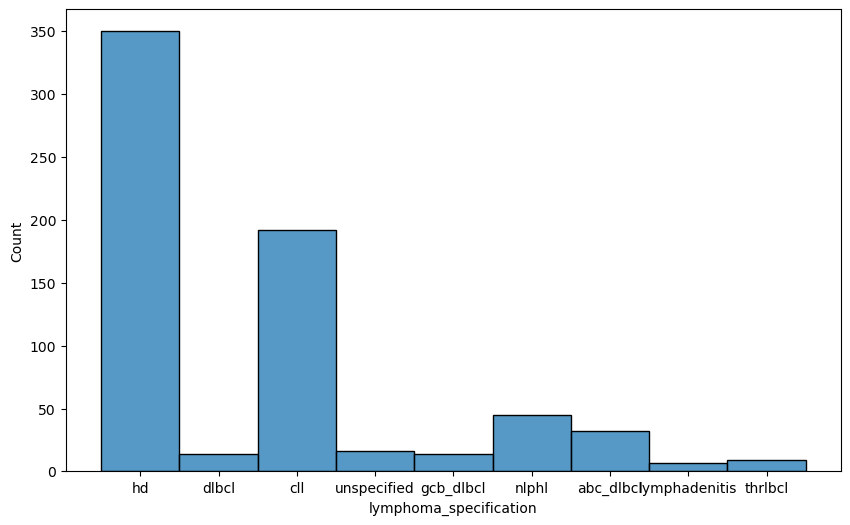

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df.groupby("clones.txt.name").first().reset_index()["lymphoma_specification"],ax = ax)

In [10]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

# Mutations in Data

In [11]:
df_mutations = df[df["aaSeqCDR3"].apply(lambda x: "_" in x or "*" in x)]
mutations_per_group = df_mutations.groupby("lymphoma_specification").apply(len).reset_index()
total_per_group = df.groupby("lymphoma_specification").apply(len).reset_index()

In [12]:
total_per_group

,lymphoma_specification,0
0,abc_dlbcl,8846
1,cll,101752
2,dlbcl,8955
3,gcb_dlbcl,2498
4,hd,1162418
5,lymphadenitis,46484
6,nlphl,181327
7,thrlbcl,14480
8,unspecified,19853


In [13]:
mutations_per_group

,lymphoma_specification,0
0,abc_dlbcl,859
1,cll,15315
2,dlbcl,1204
3,gcb_dlbcl,314
4,hd,170284
5,lymphadenitis,4951
6,nlphl,20802
7,thrlbcl,1557
8,unspecified,2494


In [14]:
mutations_per_group[0]/total_per_group[0]

0    0.097106
1    0.150513
2    0.134450
3    0.125701
4    0.146491
5    0.106510
6    0.114721
7    0.107528
8    0.125623
Name: 0, dtype: float64

## % Mutations per Group

Text(0, 0.5, 'non-productive AA (%)')

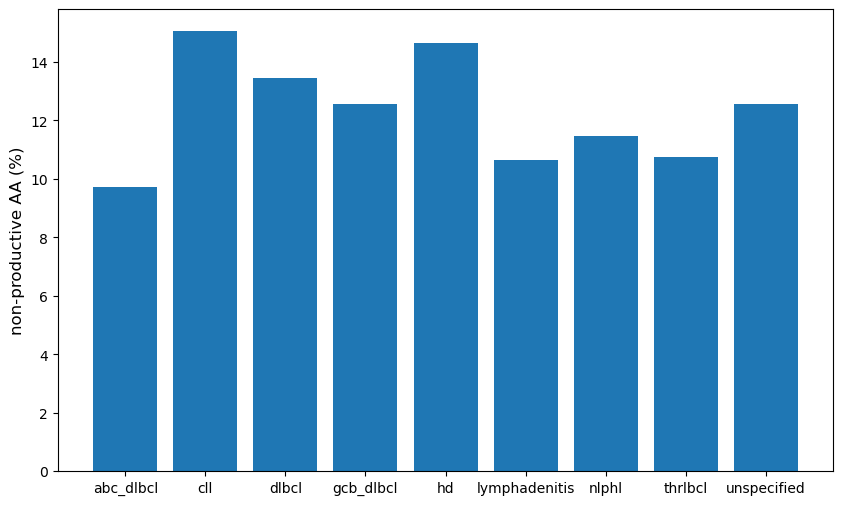

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mutations_per_group["lymphoma_specification"],mutations_per_group[0]/total_per_group[0] * 100)
ax.set_ylabel("non-productive AA (%)", size=12)

In [16]:
mutations_per_patient = df_mutations.groupby("clones.txt.name").apply(len).reset_index()
total_per_patient = df.groupby("clones.txt.name").apply(len).reset_index()

In [17]:
mutations_per_patient = mutations_per_patient.merge(total_per_patient, on="clones.txt.name",how="left")

In [18]:
mutations_per_patient = mutations_per_patient.merge(df_mutations[["clones.txt.name","lymphoma_specification"]], on="clones.txt.name", how="left")

In [29]:
mutations_per_patient["non-productive AA (%)"] = mutations_per_patient["0_x"]/mutations_per_patient["0_y"] * 100

In [20]:
mutations_per_patient.sort_values(by="lymphoma_specification", inplace = True)

## % Mutations per patient in groups

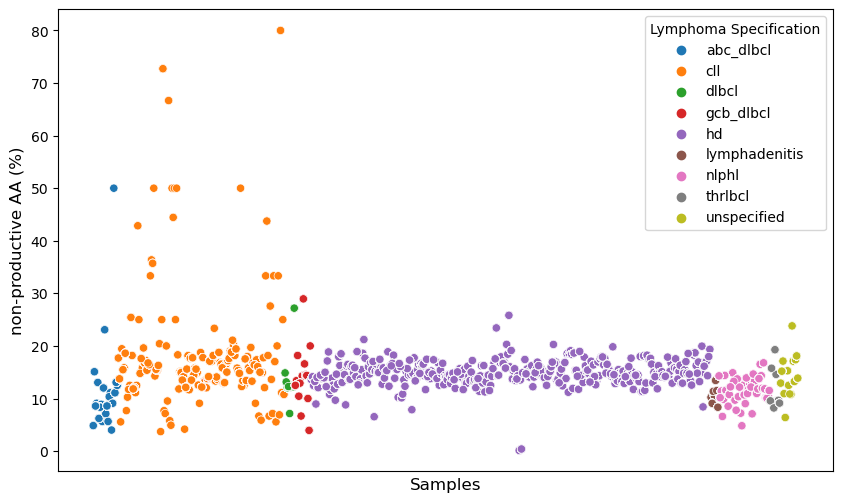

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='clones.txt.name', y='non-productive AA (%)', hue='lymphoma_specification', data=mutations_per_patient) 
ax.set_xticks([])
ax.set_ylabel("non-productive AA (%)", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Lymphoma Specification')
plt.show()

In [364]:
df[df["lymphoma_specification"] == "dlbcl"].age.isnull()

453878     True
453879     True
453880     True
453881     True
453882     True
           ... 
1388423    True
1388424    True
1388425    True
1388426    True
1388427    True
Name: age, Length: 8955, dtype: bool

In [374]:
df_age = df.groupby("clones.txt.name").first().reset_index()
age_per_group = df_age.groupby("lymphoma_specification")
age_per_group_median = age_per_group["age"].apply(np.nanmedian).reset_index()
print(age_per_group_median, "\n")

for key, group in age_per_group:
    print(key, sum(group["age"].isnull()), "%2.f %%" % (sum(group["age"].isnull())/len(group) * 100))

  lymphoma_specification   age
0              abc_dlbcl  71.0
1                    cll  66.0
2                  dlbcl   NaN
3              gcb_dlbcl   NaN
4                     hd  37.0
5          lymphadenitis  24.0
6                  nlphl  37.0
7                thrlbcl  40.0
8            unspecified  23.5 

abc_dlbcl 0  0 %
cll 37 19 %
dlbcl 14 100 %
gcb_dlbcl 14 100 %
hd 58 17 %
lymphadenitis 0  0 %
nlphl 2  4 %
thrlbcl 4 44 %
unspecified 14 88 %


All-NaN slice encountered


In [377]:
# for dlbcl, gcb_dlbcl set median to 71 (abc_dlbcl)
age_per_group_median.loc[age_per_group_median["lymphoma_specification"].isin(["dlbcl", "gcb_dlbcl"]), "age"] = 71.0

In [378]:
age_per_group_median

,lymphoma_specification,age
0,abc_dlbcl,71.0
1,cll,66.0
2,dlbcl,71.0
3,gcb_dlbcl,71.0
4,hd,37.0
5,lymphadenitis,24.0
6,nlphl,37.0
7,thrlbcl,40.0
8,unspecified,23.5


# Classification of Data

In [2]:
df = pd.read_pickle("immusign/immusign_40000_reads_with_out_of_frame_merged_raw_data_cleaned.pkl")

In [3]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [3]:
# Shannon = 0 --> Eveness = 0 -- > Clonality = 1
df.loc[df["Clonality"].isnull(),"Clonality"] = 1.0

In [4]:
top_n_clones = 20

In [422]:
#df_age_above_60 = df[df.age > 60]

In [55]:
wide_format =False
if wide_format:
    X = utils.get_top_n_features_wide(df, ["lymphoma_specification"], ['bestVGene', "has_mutation", 'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp', 'lengthOfCDR3', 'KF1', 'KF2',
       'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'], top_n_clones=top_n_clones, keep_remaining_columns=False)

    for column in X.columns:
        if X[column].dtype == float:
            if np.sum(X[column].isnull()):
                X[column] = X[column].fillna(0)
        elif X[column].dtype == object:
            if type(X[column].iloc[0]) == bool:
                if np.sum(X[column].isnull()):
                    X[column] = X[column].fillna(False)
            elif type(X[column].iloc[0]) == str:
                if np.sum(X_wide[column].isnull()):
                    X[column] = X[column].fillna("nan")
else:
    feature_list = ["clones.txt.name", "cloneId", "lymphoma_specification", 'bestVGene', "has_mutation", 'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp', 'lengthOfCDR3', 'KF1', 'KF2',
       'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10']
    
    df_top_n = utils.get_top_n_clones(df, top_n_clones = top_n_clones)
    X = df_top_n[feature_list].copy()


## Get info about nan values

In [56]:
for column in X.columns:
    print(column + " :", "%.2f %%" % (X[column].isnull().sum()/len(X)*100), X[column].dtype)

clones.txt.name : 0.00 % object
cloneId : 0.00 % object
lymphoma_specification : 0.00 % object
bestVGene : 0.00 % object
has_mutation : 0.00 % bool
Read.proportion : 0.00 % float64
Clonality : 0.00 % float64
twb.shannon : 0.00 % float64
twb.simp : 0.00 % float64
lengthOfCDR3 : 0.00 % int64
KF1 : 0.00 % float64
KF2 : 0.00 % float64
KF3 : 0.00 % float64
KF4 : 0.00 % float64
KF5 : 0.00 % float64
KF6 : 0.00 % float64
KF7 : 0.00 % float64
KF8 : 0.00 % float64
KF9 : 0.00 % float64
KF10 : 0.00 % float64


## Sex and Age as predictor 
- can be important but in our case should be balanced (e.g. undpsecified and hd younger)
- for df_age_above_60 age less important role 

In [373]:
#X["sex"] = X["sex"].fillna(X['sex'].value_counts().index[0])

In [387]:
# fill age with group median: 

#for i,row in age_per_group_median.iterrows():
#    X.loc[(X["lymphoma_specification"] == row.lymphoma_specification) & (X["age"].isnull()), "age"] = row.age

In [28]:
#X.dropna(axis=0, inplace = True)

In [122]:
#X = X[~(X["lymphoma_specification"] == 'unspecified')]

# Feature Preprocessing

In [57]:
def custom_combiner(feature, category):
    return str(feature) + "_" + str(category)

In [58]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

categorical_preprocessor = OneHotEncoder(handle_unknown = 'ignore',feature_name_combiner=custom_combiner, sparse_output=False)
numerical_preprocessor = StandardScaler()
target_preprocessor = LabelEncoder()

In [216]:
X = X[~(X["lymphoma_specification"] == 'unspecified')]

In [217]:
X = X[~(X["lymphoma_specification"] == 'lymphadenitis')]

In [218]:
X = X[~(X["lymphoma_specification"] == 'thrlbcl')]

In [219]:
X = X[~(X["lymphoma_specification"] == 'nlphl')]

In [59]:
X["lymphoma_specification"].unique()

array(['hd', 'dlbcl', 'cll', 'unspecified', 'gcb_dlbcl', 'nlphl',
       'abc_dlbcl', 'lymphadenitis', 'thrlbcl'], dtype=object)

In [60]:
dlbcl_types = ["dlbcl", "gcb_dlbcl", "abc_dlbcl"]

In [222]:
X["lymphoma_specification_grouped"] = X["lymphoma_specification"].apply(lambda x: "dlbcl" if x in dlbcl_types else x)

In [61]:
Y_target = target_preprocessor.fit_transform(X["lymphoma_specification"])

In [62]:
np.unique(Y_target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [63]:
labels = []
for i in range(len(X["lymphoma_specification"].unique())):
    labels.append(np.asarray(X["lymphoma_specification"])[Y_target==i][0])

In [35]:
labels

['abc_dlbcl',
 'cll',
 'dlbcl',
 'gcb_dlbcl',
 'hd',
 'lymphadenitis',
 'nlphl',
 'thrlbcl',
 'unspecified']

In [64]:
X.insert(loc=0, column = "lymphoma_specification_encoded", value=Y_target)

In [37]:
X.columns

Index(['lymphoma_specification_encoded', 'clones.txt.name', 'cloneId',
       'lymphoma_specification', 'bestVGene', 'has_mutation',
       'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8',
       'KF9', 'KF10'],
      dtype='object')

In [65]:
columns = list(X.columns)
features = columns.copy()
for x in ["lymphoma_specification_encoded", "clones.txt.name", "lymphoma_specification", "cloneId"]:
    features.remove(x)

if wide_format: 
    categorical = ["bestVGene_%d" % (i+1) for i in range(top_n_clones)] + ["has_mutation_%d" % (i+1) for i in range(top_n_clones)]
else:
    categorical = ["bestVGene", "has_mutation"]


numerical = features
for x in categorical:
    numerical.remove(x)

In [66]:
transformed_categories = categorical_preprocessor.fit_transform(X[categorical])
transformed_categories = pd.DataFrame(data = transformed_categories, columns=categorical_preprocessor.get_feature_names_out())

X = pd.concat([X.reset_index(drop=True), transformed_categories], axis=1) 

## a) Random Splitting in Training and Test

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_target, random_state=42
)

## b) Patientwise Splitting

In [437]:
test_clones = np.asarray(X.groupby(["lymphoma_specification","clones.txt.name"]).size().reset_index().groupby("lymphoma_specification").sample(frac=0.25, random_state=42)["clones.txt.name"])

In [78]:
X_test = X[X["clones.txt.name"].isin(test_clones)]
y_test = np.asarray(X_test["lymphoma_specification_encoded"])

In [79]:
X_train = X[~X["clones.txt.name"].isin(test_clones)]
y_train = np.asarray(X_train["lymphoma_specification_encoded"])

In [70]:
print(len(test))
print(len(train))

389763
1156842


In [71]:
X_train.columns

Index(['lymphoma_specification_encoded', 'clones.txt.name',
       'lymphoma_specification', 'bestVGene', 'has_mutation',
       'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8',
       'KF9', 'KF10'],
      dtype='object')

In [80]:
X_train.iloc[:, 5:] = numerical_preprocessor.fit_transform(X_train.iloc[:, 5:])
X_test.iloc[:, 5:] = numerical_preprocessor.transform(X_test.iloc[:, 5:])

In [81]:
transformed_categories_train = categorical_preprocessor.fit_transform(X_train.iloc[:,3:5])
transformed_categories_test = categorical_preprocessor.transform(X_test.iloc[:,3:5])

In [82]:
transformed_categories_train = pd.DataFrame(data = transformed_categories_train, columns=categorical_preprocessor.get_feature_names_out())
transformed_categories_test = pd.DataFrame(data = transformed_categories_test, columns=categorical_preprocessor.get_feature_names_out())

In [83]:
X_train = pd.concat([X_train.reset_index(drop=True), transformed_categories_train], axis=1) 
X_test = pd.concat([X_test.reset_index(drop=True), transformed_categories_test], axis=1) 

In [84]:
X_train.columns

Index(['lymphoma_specification_encoded', 'clones.txt.name',
       'lymphoma_specification', 'bestVGene', 'has_mutation',
       'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3',
       ...
       'bestVGene_TRBV7-3', 'bestVGene_TRBV7-4', 'bestVGene_TRBV7-5',
       'bestVGene_TRBV7-6', 'bestVGene_TRBV7-7', 'bestVGene_TRBV7-8',
       'bestVGene_TRBV7-9', 'bestVGene_TRBV9', 'has_mutation_False',
       'has_mutation_True'],
      dtype='object', length=164)

## c) Groupwise K-Fold Cross Validation

In [68]:
lymphoma_fold_dict,  train_fold_patients, test_fold_patients = utils.grouped_patientwise_k_folds(X, "lymphoma_specification_encoded", "clones.txt.name")

In [16]:
X.columns[6:21]

Index(['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8',
       'KF9', 'KF10'],
      dtype='object')

In [69]:
X_train_folds = []
y_train_folds = []
X_test_folds = []
y_test_folds = []

for i, train_fold in enumerate(tqdm(train_fold_patients)):
    test_fold = test_fold_patients[i]
    X_test = X[X["clones.txt.name"].isin(test_fold)]
    y_test = np.asarray(X_test["lymphoma_specification_encoded"])

    X_train = X[X["clones.txt.name"].isin(train_fold)]
    y_train = np.asarray(X_train["lymphoma_specification_encoded"])

    X_train.loc[:, numerical] = numerical_preprocessor.fit_transform(X_train.loc[:, numerical])
    X_test.loc[:, numerical] = numerical_preprocessor.transform(X_test.loc[:, numerical])

    X_train_folds.append(X_train)
    X_test_folds.append(X_test)

    y_train_folds.append(y_train)
    y_test_folds.append(y_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [70]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [71]:
sampling_strategies = {
    'None': None,
    'adasyn': ADASYN(random_state=42),
    'random_over': RandomOverSampler(random_state=42),
    'smote': SMOTE(random_state=42),
    'random_under' : RandomUnderSampler(random_state=42)
}

# ADASYN improved version of smote (KNN) synthetic data
# Under sampling --> loose data 
# Over sampling --> see datapoints multiple times generalization?

In [20]:
sampler = sampling_strategies["adasyn"]

# Random Forrest vs. Logistic Regression vs. SVM

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [74]:
features_fit = list(X.columns)
for x in (categorical + ["lymphoma_specification_encoded", "clones.txt.name", "lymphoma_specification", "cloneId"]):
    features_fit.remove(x)

In [75]:
fold_predictions = {"tree": [], "svm" : [], "reg" : []}
coefficients = {"tree": [], "svm" : [], "reg" : []}

In [76]:
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_test = X_test_folds[i]
    y_test = y_test_folds[i]
    
    X_train, y_train = sampler.fit_resample(X_train.loc[:,features_fit], y_train)

    # random forrest
    model_tree_i = RandomForestClassifier(random_state=42)
    model_tree_i.fit(X_train, y_train)

    # logistic regression 
    model_reg_i = LogisticRegression()
    model_reg_i.fit(X_train, y_train)

    # SVM + RBF
    model_svm_i = SVC(kernel='rbf')
    model_svm_i.fit(X_train, y_train)

    y_pred = model_tree_i.predict(X_test.loc[:,features_fit])
    fold_predictions["tree"].append(y_pred)

    y_pred = model_reg_i.predict(X_test.loc[:,features_fit])
    fold_predictions["reg"].append(y_pred)

    y_pred = model_svm_i.predict(X_test.loc[:,features_fit])
    fold_predictions["svm"].append(y_pred)

    coefficients["tree"].append(model_tree_i.feature_importances_)
    coefficients["reg"].append(model_reg_i.coef_)
    #coefficients_reg.append(model_svm_i.coef_)
     
    # Fits the explainer
    #explainer = shap.Explainer(model_reg_i.predict, X_test.iloc[:,7:])
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(X_test.iloc[:,7:])
    #shap_values_reg.append(shap_values)

  0%|          | 0/5 [00:00<?, ?it/s]

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [77]:
classification_reports = {"tree" : [], "svm": [], "reg": []}
average_classification_reports = {"tree" : "", "svm": "", "reg": ""}

for key in classification_reports.keys():    
    for i, y_pred in enumerate(tqdm(fold_predictions[key])):
        target_names_in_targets = np.unique(y_test_folds[i])
        target_names = [labels[i] for i in target_names_in_targets]
        classification_reports[key].append(classification_report(y_test_folds[i], y_pred, target_names=np.asarray(target_names),output_dict=True))

    average_classification_reports[key] = utils.get_averaged_classification_report(classification_reports[key])

print("Random Forrest Classifier")
print(average_classification_reports["tree"])
print("\n\n")
print("SVM + RBF Kernel")
print(average_classification_reports["svm"])
print("\n\n")
print("Logistic Regression")
print(average_classification_reports["reg"])

  0%|          | 0/5 [00:00<?, ?it/s]

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Random Forrest Classifier
               precision    recall  f1-score   support

    abc_dlbcl       0.35      0.45      0.38     89.80
          cll       0.68      0.75      0.71    550.80
        dlbcl       0.12      0.13      0.11     42.40
    gcb_dlbcl       0.36      0.30      0.30     52.00
           hd       0.89      0.87      0.88   1400.00
lymphadenitis       0.38      0.35      0.36     28.00
        nlphl       0.65      0.66      0.65    180.00
      thrlbcl       0.36      0.06      0.08     36.00
  unspecified       0.43      0.34      0.37     64.00

     accuracy                           0.75   2443.00
    macro avg       0.47      0.43      0.43   2443.00
 weighted avg       0.76      0.75      0.75   2443.00




SVM + RBF Kernel
               precision    recall  f1-score   support

    abc_dlbcl       0.35      0.48      0.40     89.80
          cll       0.62      0.69      0.65    550.80
        dlbcl       0.11      0.13      0.11     42.40
    gcb_dlbcl  

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

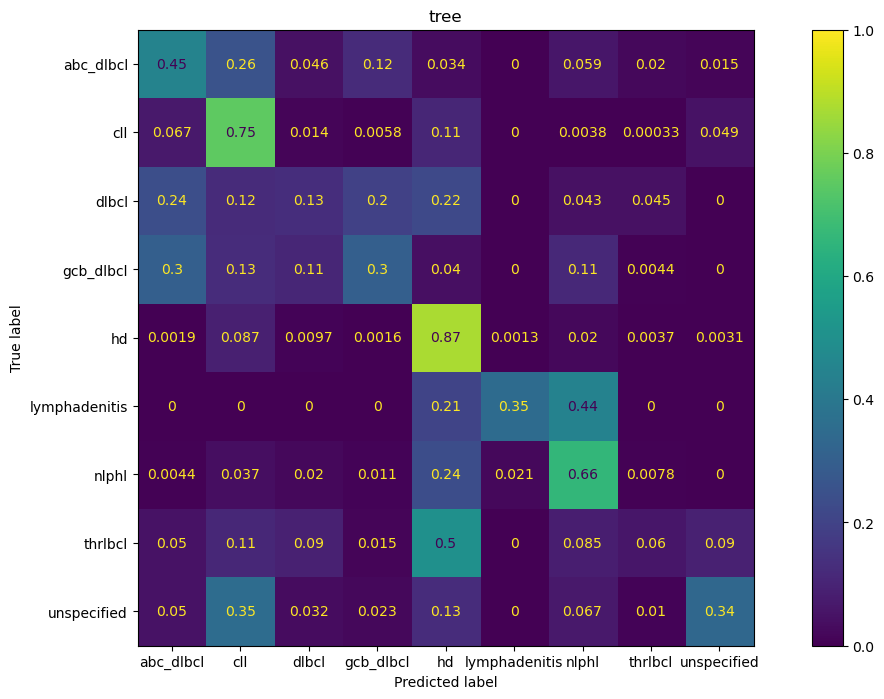

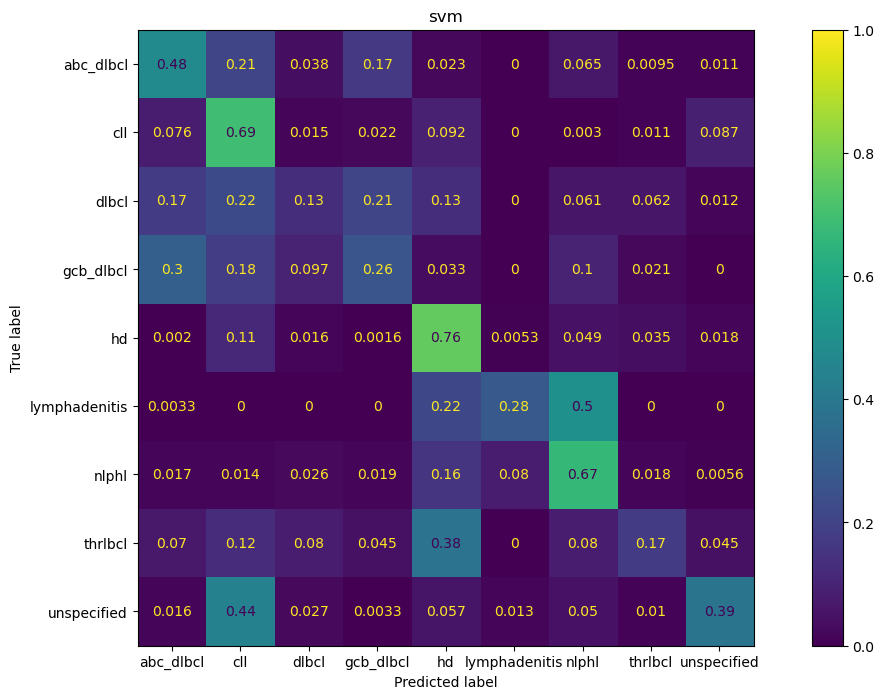

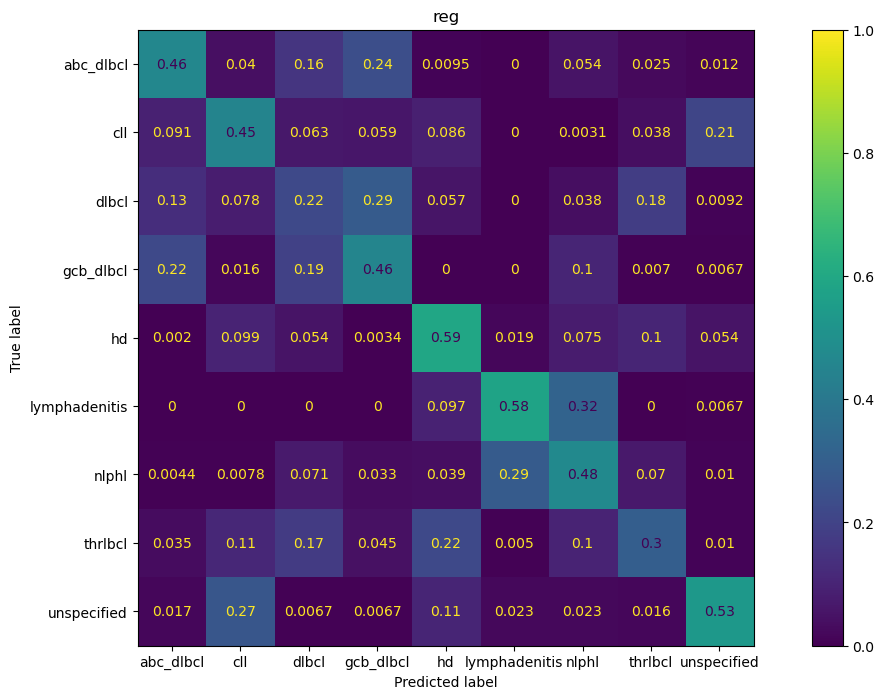

In [78]:
for key in fold_predictions.keys():
    cms = []
    for i, y_pred in enumerate(tqdm(fold_predictions[key])):
        cm = confusion_matrix(y_test_folds[i], y_pred, normalize="true") # normalize over true values
        cms.append(cm)
    cms = np.asarray(cms)
    
    fig, ax = plt.subplots(figsize = (15,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels,)
    ax.set_title(key)
    disp.plot(ax=ax)
    disp.ax_.get_images()[0].set_clim(0, 1)

## Feature Importance

(129,)


Text(0.5, 1.0, 'tree')

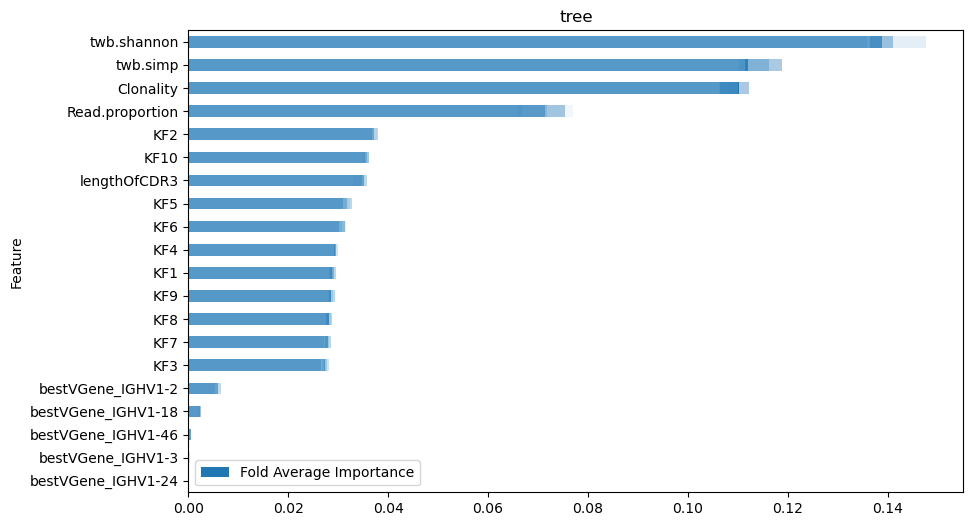

In [79]:
key="tree"
mean_coef = np.mean(np.asarray(coefficients[key]), axis=0)
print(mean_coef.shape)
palette = sns.color_palette(palette='Blues')

fig, ax = plt.subplots(figsize=(10, 6))
feature_importance = pd.DataFrame({'Feature': X_train.columns[0:20], 'Importance': mean_coef[0:20]})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', ax=ax, label = "Fold Average Importance")

for i, cof in enumerate(coefficients[key]):
    feature_importance_i = pd.DataFrame({'Feature': X_train.columns[:20], 'Importance': cof[0:20]})
    feature_importance_i = feature_importance_i.sort_values('Importance', ascending=True)
    feature_importance_i.plot(x='Feature', y='Importance', kind='barh', ax=ax, color =palette[i], alpha=0.4, label="", legend=False)
ax.set_title(key)

#feature_importance = pd.DataFrame({'Feature': X_train.columns[:10], 'Importance': coefficients[0:10]})
#feature_importance = feature_importance.sort_values('Importance', ascending=True)
#feature_importance.plot(x='Feature', y='Importance', kind='barh',alpha=0.0 , hatch = "/", ax=ax , legend = False)

# CatBoost

In [80]:
from catboost import CatBoostClassifier 

In [81]:
fold_predictions["cat"] =  []
coefficients["cat"] = []

In [82]:
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_test = X_test_folds[i]
    y_test = y_test_folds[i]
    
    X_train, y_train = sampler.fit_resample(X_train.loc[:,features_fit], y_train)

    model_tree_i.fit(X_train, y_train)
    
    model_cat_i = CatBoostClassifier(loss_function='MultiClass', verbose=False)
    model_cat_i.fit(X_train, y_train)

    y_pred = model_cat_i.predict(X_test.loc[:,features_fit])
    fold_predictions["cat"].append(y_pred)

    coefficients["cat"].append(model_cat_i.feature_importances_)

  0%|          | 0/5 [00:00<?, ?it/s]

In [83]:
key = "cat"
classification_reports[key] = []
for i, y_pred in enumerate(tqdm(fold_predictions[key])):
        target_names_in_targets = np.unique(y_test_folds[i])
        target_names = [labels[i] for i in target_names_in_targets]
        classification_reports[key].append(classification_report(y_test_folds[i], y_pred, target_names=np.asarray(target_names),output_dict=True))

average_classification_reports[key] = utils.get_averaged_classification_report(classification_reports[key])

print("CatBoost Classifier")
print(average_classification_reports[key])

  0%|          | 0/5 [00:00<?, ?it/s]

CatBoost Classifier
               precision    recall  f1-score   support

    abc_dlbcl       0.36      0.39      0.36     89.80
          cll       0.68      0.73      0.70    550.80
        dlbcl       0.07      0.10      0.07     42.40
    gcb_dlbcl       0.44      0.40      0.39     52.00
           hd       0.90      0.86      0.88   1400.00
lymphadenitis       0.42      0.50      0.40     28.00
        nlphl       0.66      0.71      0.68    180.00
      thrlbcl       0.04      0.05      0.04     36.00
  unspecified       0.32      0.30      0.31     64.00

     accuracy                           0.74   2443.00
    macro avg       0.43      0.45      0.43   2443.00
 weighted avg       0.76      0.74      0.75   2443.00



  0%|          | 0/5 [00:00<?, ?it/s]

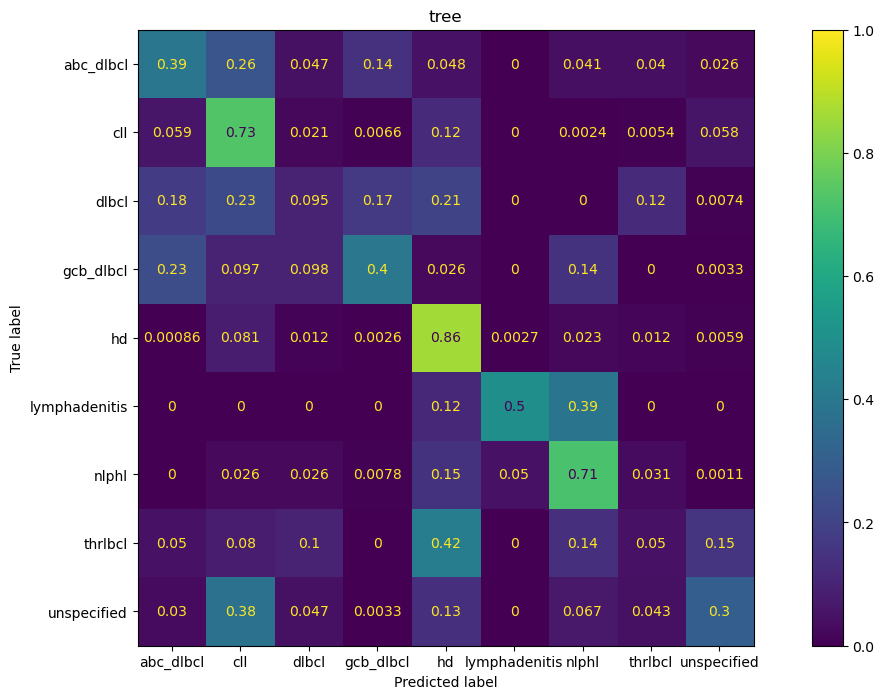

In [84]:
cms = []
for i, y_pred in enumerate(tqdm(fold_predictions[key])):
    cm = confusion_matrix(y_test_folds[i], y_pred, normalize="true") # normalize over true values
    cms.append(cm)
cms = np.asarray(cms)

fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels,)
ax.set_title(key)
disp.plot(ax=ax)
disp.ax_.get_images()[0].set_clim(0, 1)

(129,)


Text(0.5, 1.0, 'cat')

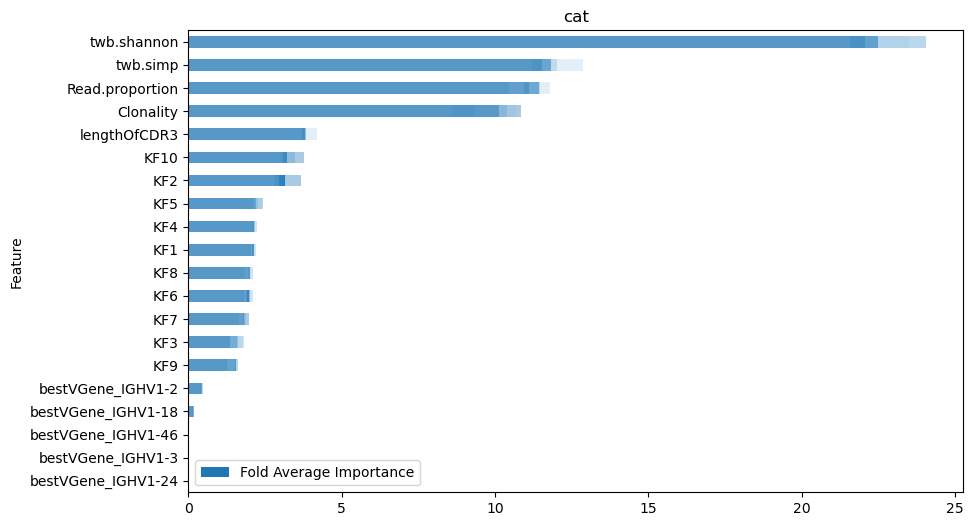

In [85]:
key="cat"
mean_coef = np.mean(np.asarray(coefficients[key]), axis=0)
print(mean_coef.shape)
palette = sns.color_palette(palette='Blues')

fig, ax = plt.subplots(figsize=(10, 6))
feature_importance = pd.DataFrame({'Feature': X_train.columns[0:20], 'Importance': mean_coef[0:20]})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', ax=ax, label = "Fold Average Importance")

for i, cof in enumerate(coefficients[key]):
    feature_importance_i = pd.DataFrame({'Feature': X_train.columns[:20], 'Importance': cof[0:20]})
    feature_importance_i = feature_importance_i.sort_values('Importance', ascending=True)
    feature_importance_i.plot(x='Feature', y='Importance', kind='barh', ax=ax, color =palette[i], alpha=0.4, label="", legend=False)
ax.set_title(key)

#feature_importance = pd.DataFrame({'Feature': X_train.columns[:10], 'Importance': coefficients[0:10]})
#feature_importance = feature_importance.sort_values('Importance', ascending=True)
#feature_importance.plot(x='Feature', y='Importance', kind='barh',alpha=0.0 , hatch = "/", ax=ax , legend = False)

# ANN

In [268]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [90]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/labadmin/Projects/immusign/utils.py'>

In [295]:
from sklearn.model_selection import train_test_split

In [ ]:
labels = ['abc_dlbcl', 'cll', 'dlbcl', 'gcb_dlbcl', 'hd', 'lymphadenitis', 'nlphl', 'thrlbcl', 'unspecified']

In [124]:
lymphoma_specification_dict = {}
for i, label in enumerate(labels):
    one_hot_vec = np.zeros(len(labels)) 
    one_hot_vec[i] = 1
    lymphoma_specification_dict[label] = one_hot_vec

In [92]:
df_top_n.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [320]:
X = df_top_n["CDR3.nucleotide.sequence"].apply(utils.encode_nucleotides)
Y = df_top_n["lymphoma_specification"].apply(lambda x: np.asarray(lymphoma_specification_dict[x]))

In [321]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, random_state=42
)

X_train_lens = X_train.apply(len)
X_valid_lens = X_valid.apply(len)

In [387]:
lymphoma_fold_dict,  train_fold_patients, test_fold_patients = utils.grouped_patientwise_k_folds(df_top_n, "lymphoma_specification", "clones.txt.name")

In [391]:
X_train_folds = []
y_train_folds = []
X_test_folds = []
y_test_folds = []

for i, train_fold in enumerate(tqdm(train_fold_patients)):
    test_fold = test_fold_patients[i]
    X_test = df_top_n[df_top_n["clones.txt.name"].isin(test_fold)]
    y_test = np.asarray(X_test["lymphoma_specification"])

    X_train = df_top_n[df_top_n["clones.txt.name"].isin(train_fold)]
    y_train = np.asarray(X_train["lymphoma_specification"])

    X_train_folds.append(X_train)
    X_test_folds.append(X_test)

    y_train_folds.append(y_train)
    y_test_folds.append(y_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [394]:
X_train = X_train_folds[0]["CDR3.nucleotide.sequence"].apply(utils.encode_nucleotides)
Y_train = X_train_folds[0]["lymphoma_specification"].apply(lambda x: np.asarray(lymphoma_specification_dict[x]))

X_valid = X_test_folds[0]["CDR3.nucleotide.sequence"].apply(utils.encode_nucleotides)
Y_valid = X_test_folds[0]["lymphoma_specification"].apply(lambda x: np.asarray(lymphoma_specification_dict[x]))

In [395]:
X_train_lens = X_train.apply(len)
X_valid_lens = X_valid.apply(len)

In [396]:
length_with_index_dict = {}
lengths = np.asarray(X_train.apply(len))
for i in np.sort(np.unique(lengths)):
    length_with_index_dict[i] = np.where(lengths == i)[0]

In [397]:
torch.manual_seed(SEED)

In [398]:
INPUT_DIM = 4
NUM_HIDDEN_NODES = 128
NUM_OUTPUT_NODES = 9
NUM_LAYERS = 2
DROPOUT = 0.5

In [399]:
importlib.reload(model_zoo)

<module 'model_zoo' from '/Users/labadmin/Projects/immusign/model_zoo.py'>

In [325]:
import model_zoo

In [354]:
model = model_zoo.LSTMNet(INPUT_DIM, 
                 NUM_OUTPUT_NODES, 
                 lstm_layers=2,
                 lstm_units=128,
                 bidirectional=True,
                 dropout=0.5,
                 fc_layer=2,
                 fc_hidden_dim=256,
               )

In [406]:
model = model_zoo.NonLinearModel(input_channel=INPUT_DIM,
                 output_channel=NUM_OUTPUT_NODES,
                 hidden_units = 256,)

In [250]:
model = ResnetModel(input_channel=INPUT_DIM,output_channel=NUM_OUTPUT_NODES,hidden_layers=NUM_LAYERS,hidden_units=NUM_HIDDEN_NODES)

In [301]:
# per patient
#class_counts = df.groupby(["lymphoma_specification", "clones.txt.name"]).size().reset_index().groupby("lymphoma_specification").size().reset_index()
# per clone
class_counts = df.groupby(["lymphoma_specification"]).size()
total_samples = sum(class_counts.values)
class_weights = [total_samples / (class_counts[i] * len(class_counts)) for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights)

In [407]:
device = torch.device("mps")
#device = torch.device("cpu")
import torch.optim as optim
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()

In [408]:
model.train()

NonLinearModel(
  (activation_function): LeakyReLU(negative_slope=0.01)
  (non_linear): Linear(in_features=4, out_features=256, bias=True)
  (linear): Linear(in_features=256, out_features=9, bias=True)
)

In [410]:
BATCH_SIZE =16
N_EPOCHS = 100

In [411]:
epoch_loss = []
epoch_acc = []
for ii in tqdm(range(N_EPOCHS), desc ='Training...',position=0,leave=True):
    average_epoch_loss = []
    average_epoch_metric = []
    average_epoch_acc = []
    
    running_loss = 0.0
    epoch = create_epoch_with_same_size_batching(length_with_index_dict, BATCH_SIZE , shuffle=True)

    for jj, idxs in enumerate(tqdm(epoch,desc = "Batch...",position=1, leave=False)): #enumerate(epoch):
        model.train()
        # index by indices in batch

        batch_input_jj = X_train.iloc[idxs]
        
        batch_input_jj_lens = torch.from_numpy(X_train_lens.iloc[idxs].values)#.to(device)
        
        batch_input = pad_batch_online(batch_input_jj_lens, batch_input_jj, style="zero")
        batch_input = torch.from_numpy(batch_input).to(device, dtype=torch.float32)

       
        Y_hat = model(batch_input, batch_input_jj_lens)

        batch_output_jj = torch.from_numpy(np.stack(Y_train.iloc[idxs].values)).to(device, dtype=torch.float32)


        optimizer.zero_grad() # set gradients to zero before performing backprop
        loss = criterion(Y_hat.squeeze(), batch_output_jj.to(torch.float32))
        average_epoch_loss += [loss.item()]
        
        #f1score = metric(Y_hat, batch_output_jj)
        #average_epoch_metric += [f1score.item()]
        
        running_loss += loss.item()
        loss.backward()  # compute dloss/dx and accumulated into x.grad
        optimizer.step()  # compute x += -learning_rate * x.grad

        model.eval()
        Y_hat = model(batch_input, batch_input_jj_lens)
        Y_hat = torch.nn.functional.softmax(Y_hat, dim=1)
        
        pred_labels = np.argmax(Y_hat.detach().cpu().numpy(),axis=1)
        true_labels = np.argmax(batch_output_jj.detach().cpu().numpy(), axis=1)
        
        acc = np.mean(pred_labels == true_labels)
        average_epoch_acc += [acc]
    
    epoch_loss += [np.mean(average_epoch_loss)]
    epoch_acc += [np.mean(average_epoch_acc)]
    #print("Avg Training Loss: " + str(np.mean(average_epoch_loss)) + "\n" +
    #      #"Avg Training Score: " + str(np.mean(average_epoch_metric)) + "\n" +
    #      "Running Training Loss: " + str(float(running_loss)))
    #time.sleep(0.1)
    

Training...:   0%|          | 0/100 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

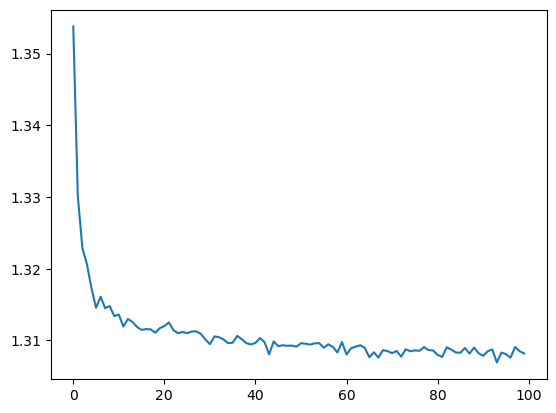

In [412]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_loss )), epoch_loss)

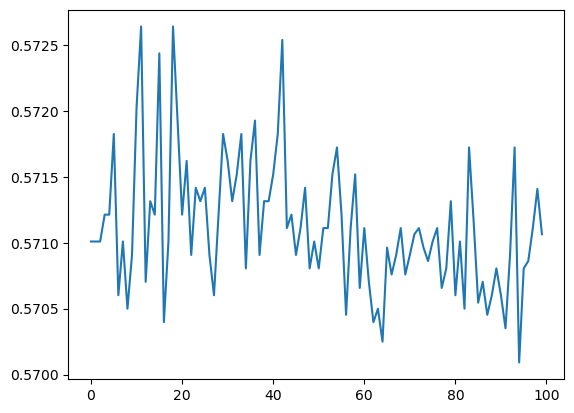

In [413]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_acc)), epoch_acc)

In [414]:
model.eval()
true_labels = []
pred_labels = []

for i,x in enumerate(tqdm(X_valid)):
    x_lens = torch.Tensor([X_valid_lens.iloc[i]])
    x = torch.from_numpy(np.expand_dims(X_valid.iloc[i],axis=0)).to(torch.float32).to(device)
    output = model(x, x_lens)
    Y_hat = torch.nn.functional.softmax(output, dim=1)
    
    batch_output_jj = torch.from_numpy(Y_valid.iloc[i]).to(device,dtype=torch.float32)
           
    pred_labels += [np.argmax(Y_hat.detach().cpu().numpy(),axis=1)]
    true_labels += [np.argmax(batch_output_jj.detach().cpu().numpy())]

  0%|          | 0/2412 [00:00<?, ?it/s]

In [415]:
print(classification_report(true_labels, pred_labels, target_names=np.asarray(target_names),output_dict=False))

               precision    recall  f1-score   support

    abc_dlbcl       0.00      0.00      0.00        83
          cll       1.00      0.00      0.00       543
        dlbcl       0.00      0.00      0.00        26
    gcb_dlbcl       0.00      0.00      0.00        60
           hd       0.58      1.00      0.73      1400
lymphadenitis       0.00      0.00      0.00        20
        nlphl       0.00      0.00      0.00       180
      thrlbcl       0.00      0.00      0.00        40
  unspecified       0.00      0.00      0.00        60

     accuracy                           0.58      2412
    macro avg       0.18      0.11      0.08      2412
 weighted avg       0.56      0.58      0.43      2412



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Stacked and padded input to SVM

input = pad_batch_online(X_train_lens, X_train, style="zero").reshape((X_train.shape[0],-1))

In [184]:
input_valid = pad_batch_online(X_valid_lens, X_valid, style="zero").reshape((X_valid.shape[0],-1))

In [185]:
model = SVC(kernel='rbf')
model.fit(input, Y_train.apply(lambda x: np.where(x==1)[0][0]))

SVC()

In [186]:
Y_valid.apply(lambda x: np.where(x==1)[0][0]).unique()

array([2, 0, 3, 1, 5])

In [187]:
Y_pred = model.predict(input_valid)

In [190]:
np.unique(Y_pred)

array([0, 1, 2, 3, 5])

In [191]:
print(classification_report(Y_valid.apply(lambda x: np.where(x==1)[0][0]), Y_pred, ))

              precision    recall  f1-score   support

           0       0.56      0.87      0.68       133
           1       0.84      0.28      0.42        57
           2       0.63      0.65      0.64       113
           3       1.00      0.19      0.32        31
           5       1.00      0.07      0.13        14

    accuracy                           0.61       348
   macro avg       0.81      0.41      0.44       348
weighted avg       0.69      0.61      0.57       348

